Reference: https://medium.com/@sdwiulfah/having-fun-with-yolov8-how-good-your-model-in-detecting-playing-card-a468a02e4775

In [14]:
!pip install ultralytics

You should consider upgrading via the 'C:\Users\soham\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\soham\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [15]:
import kagglehub
import os
import random
import cv2
import matplotlib.pyplot as plt
import torch
from ultralytics import YOLO
%matplotlib inline

# Download latest version
path = kagglehub.dataset_download("andy8744/playing-cards-object-detection-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\soham\.cache\kagglehub\datasets\andy8744\playing-cards-object-detection-dataset\versions\4


In [16]:
# Define the paths to the train, valid and test directories
train_images =  path + "\\train\\images"
train_labels = path + "\\train\\labels"

valid_images = path + "\\valid\\images"
valid_labels = path + "\\valid\\labels"

test_images = path + "\\test\\images"
test_labels = path + "\\test\\labels"

yaml_path = path + "\\data.yaml"

In [17]:
# Define the labels
classes = ['10c', '10d', '10h', '10s', '2c', '2d', '2h', '2s', '3c', '3d', '3h', '3s', '4c', '4d', '4h', '4s', '5c', '5d', '5h', '5s', '6c', '6d', '6h', '6s', '7c', '7d', '7h', '7s', '8c', '8d', '8h', '8s', '9c', '9d', '9h', '9s', 'Ac', 'Ad', 'Ah', 'As', 'Jc', 'Jd', 'Jh', 'Js', 'Kc', 'Kd', 'Kh', 'Ks', 'Qc', 'Qd', 'Qh', 'Qs']

Idx2Label = {idx: label for idx, label in enumerate(classes)}
Label2Index = {label: idx for idx, label in Idx2Label.items()}

Index to Label Mapping: {0: '10c', 1: '10d', 2: '10h', 3: '10s', 4: '2c', 5: '2d', 6: '2h', 7: '2s', 8: '3c', 9: '3d', 10: '3h', 11: '3s', 12: '4c', 13: '4d', 14: '4h', 15: '4s', 16: '5c', 17: '5d', 18: '5h', 19: '5s', 20: '6c', 21: '6d', 22: '6h', 23: '6s', 24: '7c', 25: '7d', 26: '7h', 27: '7s', 28: '8c', 29: '8d', 30: '8h', 31: '8s', 32: '9c', 33: '9d', 34: '9h', 35: '9s', 36: 'Ac', 37: 'Ad', 38: 'Ah', 39: 'As', 40: 'Jc', 41: 'Jd', 42: 'Jh', 43: 'Js', 44: 'Kc', 45: 'Kd', 46: 'Kh', 47: 'Ks', 48: 'Qc', 49: 'Qd', 50: 'Qh', 51: 'Qs'}
Label to Index Mapping: {'10c': 0, '10d': 1, '10h': 2, '10s': 3, '2c': 4, '2d': 5, '2h': 6, '2s': 7, '3c': 8, '3d': 9, '3h': 10, '3s': 11, '4c': 12, '4d': 13, '4h': 14, '4s': 15, '5c': 16, '5d': 17, '5h': 18, '5s': 19, '6c': 20, '6d': 21, '6h': 22, '6s': 23, '7c': 24, '7d': 25, '7h': 26, '7s': 27, '8c': 28, '8d': 29, '8h': 30, '8s': 31, '9c': 32, '9d': 33, '9h': 34, '9s': 35, 'Ac': 36, 'Ad': 37, 'Ah': 38, 'As': 39, 'Jc': 40, 'Jd': 41, 'Jh': 42, 'Js': 43, 'K

In [18]:
def visualize_image_with_annotation_bboxes(image_dir, label_dir):
    # Get list of all the image files in the directory
    image_files = sorted(os.listdir(image_dir))

    # Choose 12 random image files from the list
    sample_image_files = random.sample(image_files, 12)

    # Set up the plot
    fig, axs = plt.subplots(4, 3, figsize=(15, 20))

    # Loop over the random images and plot the bounding boxes
    for i, image_file in enumerate(sample_image_files):
        row = i // 3
        col = i % 3

        # Load the image
        image_path = os.path.join(image_dir, image_file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load the labels for this image
        label_path = os.path.join(label_dir, image_file[:-4] + '.txt')
        f = open(label_path, 'r')

        # Loop over the labels and plot the bounding boxes
        for label in f:
            class_id, x_center, y_center, width, height = map(float, label.split())
            h, w, _ = image.shape
            x_min = int((x_center - width/2) * w)
            y_min = int((y_center - height/2) * h)
            x_max = int((x_center + width/2) * w)
            y_max = int((y_center + height/2) * h)
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            cv2.putText(image, Idx2Label[int(class_id)], (x_min, y_min), cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)

        axs[row, col].imshow(image)
        axs[row, col].axis('off')

    plt.show()

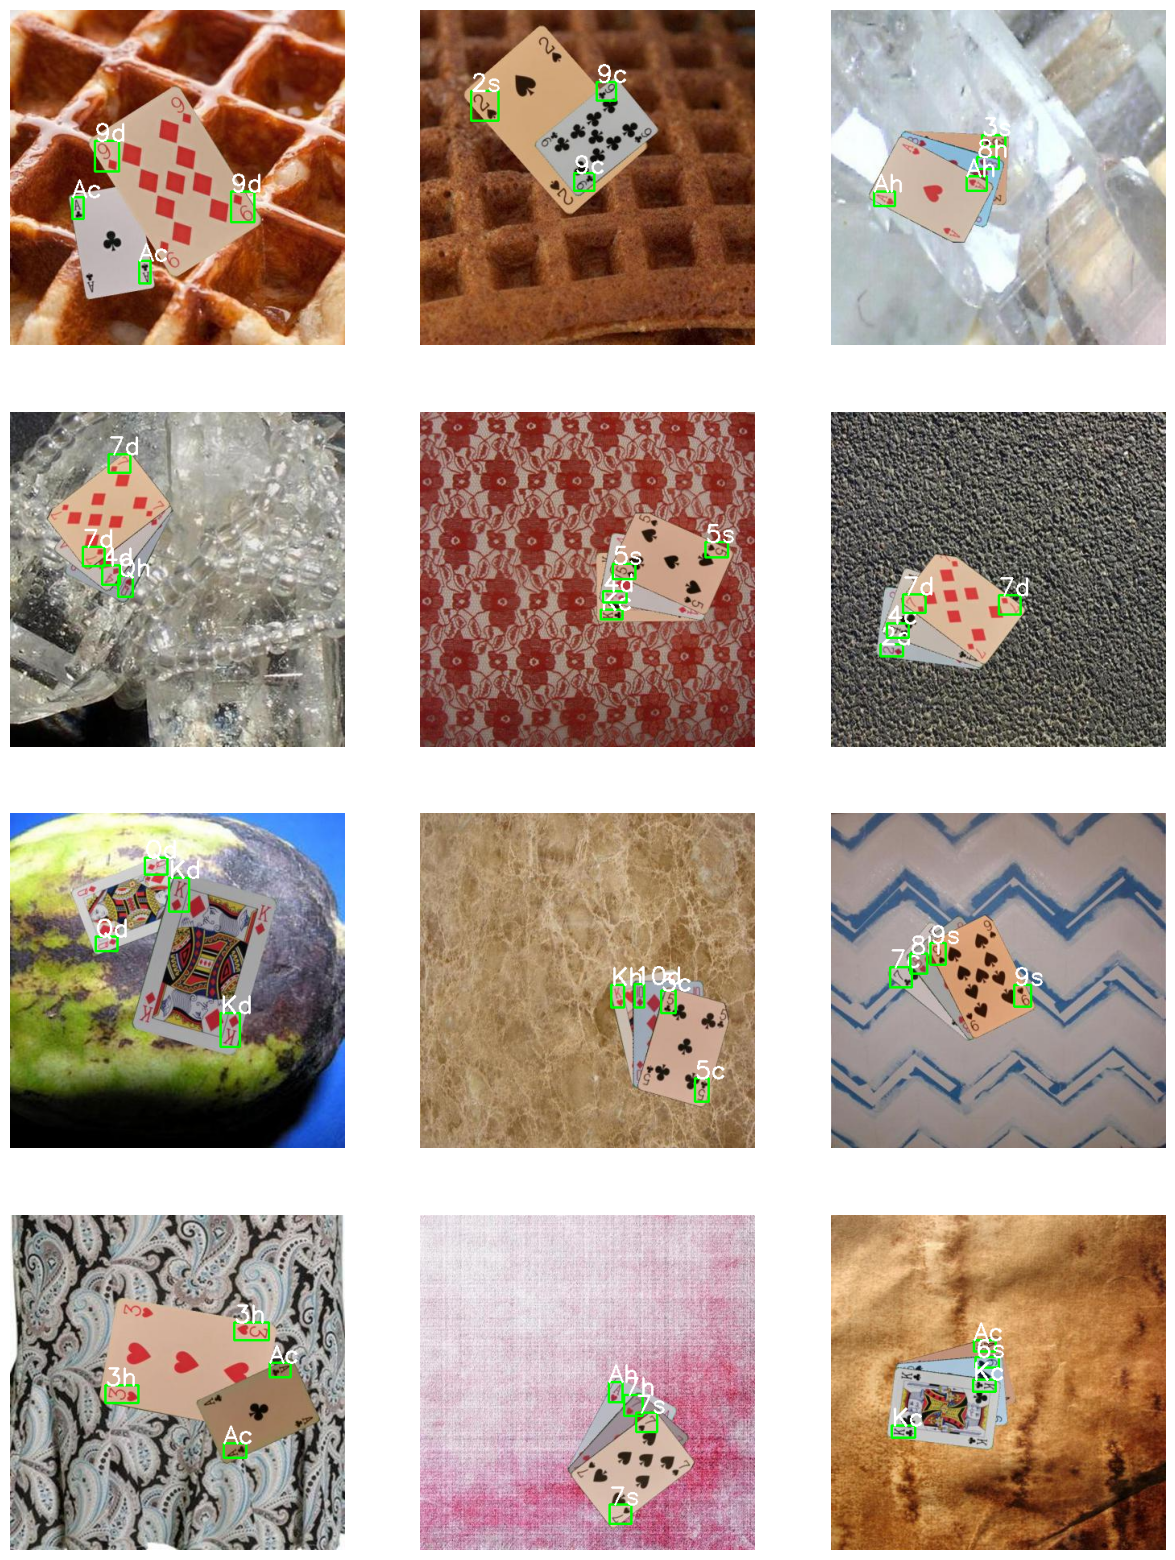

In [19]:
visualize_image_with_annotation_bboxes(train_images, train_labels)

In [20]:
# Read a image by path
image_path = os.path.join(train_images, os.listdir(train_images)[-1])
image = cv2.imread(image_path)

# Get the size of the image
height, width, channels = image.shape
print('The image has dimensions {}x{} and {} channels'.format(height, width, channels))

The image has dimensions 416x416 and 3 channels


In [ ]:
# Load a pretrained nano model
model = YOLO('yolov8n.pt')

# free up GPU memory
torch.cuda.empty_cache()

# Training the model
results = model.train(
    data= yaml_path,
    epochs = 25,
    imgsz = (height, width, channels),
    seed = 42,
    batch = 8,
    workers = 4,
    patience = 5,
    name = 'yolov8n_custom')

Ultralytics 8.3.28  Python-3.10.5 torch-2.5.1+cpu CPU (Intel Core(TM) i7-8665U 1.90GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=C:\Users\soham\.cache\kagglehub\datasets\andy8744\playing-cards-object-detection-dataset\versions\4\data.yaml, epochs=25, time=None, patience=5, batch=8, imgsz=(416, 416, 3), save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=yolov8n_custom, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fr

100%|██████████| 755k/755k [00:00<00:00, 4.80MB/s]


Overriding model.yaml nc=80 with nc=52

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

train: Scanning C:\Users\soham\.cache\kagglehub\datasets\andy8744\playing-cards-object-detection-dataset\versions\4\train\labels... 14000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 14000/14000 [01:00<00:00, 233.03it/s]


train: New cache created: C:\Users\soham\.cache\kagglehub\datasets\andy8744\playing-cards-object-detection-dataset\versions\4\train\labels.cache


val: Scanning C:\Users\soham\.cache\kagglehub\datasets\andy8744\playing-cards-object-detection-dataset\versions\4\valid\labels... 4000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4000/4000 [00:45<00:00, 87.21it/s] 


val: New cache created: C:\Users\soham\.cache\kagglehub\datasets\andy8744\playing-cards-object-detection-dataset\versions\4\valid\labels.cache
Plotting labels to runs\detect\yolov8n_custom\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000179, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 416 train, 416 val
Using 0 dataloader workers
Logging results to runs\detect\yolov8n_custom
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25         0G      2.544      6.028      1.481         40        416:   6%|▌         | 102/1750 [02:31<41:34,  1.51s/it]

In [ ]:
# Loading the best performing model
model = YOLO('/kaggle/working/runs/detect/yolov8n_custom3/weights/best.pt')

# Evaluating the model on test dataset
metrics = model.val(conf=0.25, split='test')

In [ ]:
# Function to perform detections with trained model
def predict_detection(image_path):
    # Read the image
    image = cv2.imread(image_path)

    # Pass the image through the detection model and get the result
    detect_result = model(image)

    # Plot the detections
    detect_image = detect_result[0].plot()

    # Convert the image to RGB format
    detect_image = cv2.cvtColor(detect_image, cv2.COLOR_BGR2RGB)

    return detect_image

In [ ]:
# Get list of all the image files in the test directory
image_files = sorted(os.listdir(test_images))

# Choose 12 random image files from the list
sample_image_files = random.sample(image_files, 12)

# Set up the plot
fig, axs = plt.subplots(4, 3, figsize=(15, 20))

# Loop over the random images and plot the detections of the trained model
for i, image_file in enumerate(sample_image_files):
    row = i // 3
    col = i % 3

    # Load the current image and run object detection
    image_path = os.path.join(test_images, image_file)
    detect_image = predict_detection(image_path)

    axs[row, col].imshow(detect_image)
    axs[row, col].axis('off')

plt.show()